In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
import sqlite3

In [2]:
# define the state
class State(TypedDict):
    question: str
    query: str
    result: str
    final_result: str

In [38]:
# create the model
model = ChatOllama(model="mistral")

In [39]:
# function to generate the query
def generate_query(state: State):
    print(f"going inside the generate_query: ", state)
    query_template = """
    You are a sqlite3 developer, writing sqlite3 queries.
    Use the given schema and answer users question.
    
    Question: {question}
    Schema: {schema}
    Query:
    
    Generate only the query nothing else.
    """

    # define the schema
    schema = """
    CREATE TABLE IF NOT EXISTS students (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        age INTEGER NOT NULL,
        roll_no INTEGER UNIQUE NOT NULL,
        marks REAL NOT NULL,
        standard TEXT NOT NULL,
        division TEXT NOT NULL
    );
    
    CREATE TABLE IF NOT EXISTS addresses (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        studentId INTEGER,
        street TEXT NOT NULL,
        city TEXT NOT NULL,
        state TEXT NOT NULL,
        pinCode INTEGER NOT NULL,
        FOREIGN KEY (studentId) REFERENCES students(id)
    );
    """
    
    # create the prompt template
    prompt_template = ChatPromptTemplate.from_template(template=query_template)
    prompt = prompt_template.invoke({"question": state['question'], "schema": schema})

    # invoke the prompt and get the result 
    result = model.invoke(prompt)
    query = result.content

    return {"query": query}

In [40]:
# function to execute the query and get the result
def execute_query(state: State):
    print(f"inside execute_query: ", state)

    # open the database connection
    connection = sqlite3.connect('./students.db')

    # create a cursor object
    cursor = connection.cursor()

    # execute a query
    cursor.execute(state['query'])

    # get all the results
    rows = cursor.fetchall()

    # close the connection
    connection.close()

    return {"result": rows}

In [56]:
# function to format the final output
def format_result(state: State):
    print("inside format_result: ", state)
    result_template = """
    You are a database summarizer.
    Given the users question, generated query and results found, you need to format the results accordingly.
        
    Question: {question}
    Query: {query}
    Results: {results}
    
    Print only the formatted results nothing else.
    """

    # create the result prompt template
    prompt_template = ChatPromptTemplate.from_template(template=result_template)
    prompt = prompt_template.invoke({
        "question": state['question'], 
        "query": state['query'], 
        "results": state['result']
    })
    
    # invoke the prompt and get the result
    final_result = model.invoke(prompt)
    print(final_result.content)

    return {"final_result": final_result.content}    

In [98]:
def check_condition(state: State):
    if len(state['query']) == 0:
        return "Fail"
    else:
        return "Pass"

### build the graph

In [99]:
# create the workflow/graph
workflow = StateGraph(State)

In [100]:
# add the nodes
workflow.add_node("generate_query", generate_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("format_result", format_result)

In [101]:
# add the required edges
workflow.add_edge(START, "generate_query")
workflow.add_conditional_edges("generate_query", check_condition, {"Pass": "execute_query", "Fail": END})
# workflow.add_edge("generate_query", "execute_query")
workflow.add_edge("execute_query", "format_result")
workflow.add_edge("format_result", END)

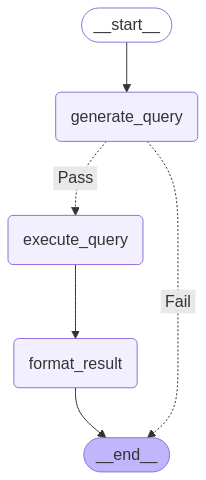

In [102]:
workflow.compile()

In [103]:
# compile the workflow and get the chain
chain = workflow.compile()

In [104]:
question = "what is the roll no of Emily Chen?"
chain.invoke({"question": question})

going inside the generate_query:  {'question': 'what is the roll no of Emily Chen?'}
inside execute_query:  {'question': 'what is the roll no of Emily Chen?', 'query': " SELECT roll_no FROM students WHERE name = 'Emily Chen';"}
inside format_result:  {'question': 'what is the roll no of Emily Chen?', 'query': " SELECT roll_no FROM students WHERE name = 'Emily Chen';", 'result': [(106,)]}
 Roll No for Emily Chen: 106


{'question': 'what is the roll no of Emily Chen?',
 'query': " SELECT roll_no FROM students WHERE name = 'Emily Chen';",
 'result': [(106,)],
 'final_result': ' Roll No for Emily Chen: 106'}